In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, power_transform, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics 
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import PolynomialFeatures

from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)

In [2]:
X_train = pd.read_csv('0_X_train.csv', index_col='Id')
X_valid = pd.read_csv('1_X_valid.csv', index_col='Id')
X_test  = pd.read_csv('2_X_test.csv', index_col='Id')

y_train = pd.read_csv('0_y_train.csv', index_col='Id')
y_valid = pd.read_csv('1_y_valid.csv', index_col='Id')
y_test  = pd.read_csv('2_y_test.csv', index_col='Id')

num_vars = ['age', 'time_spent', 'banner_views', 'banner_views_old', 'days_elapsed_old', 'X4']

In [3]:
# Keep only the continuous variables for LDA and QDA
X_train_continous = X_train[['age', 'time_spent', 'banner_views', 'banner_views_old', 'days_elapsed_old', 'X4']]

X_valid_continous = X_valid[['age', 'time_spent', 'banner_views', 'banner_views_old', 'days_elapsed_old', 'X4']]

X_test_continous = X_test[['age', 'time_spent', 'banner_views', 'banner_views_old', 'days_elapsed_old', 'X4']]

Text(0.5, 1.0, 'Correlation Matrix')

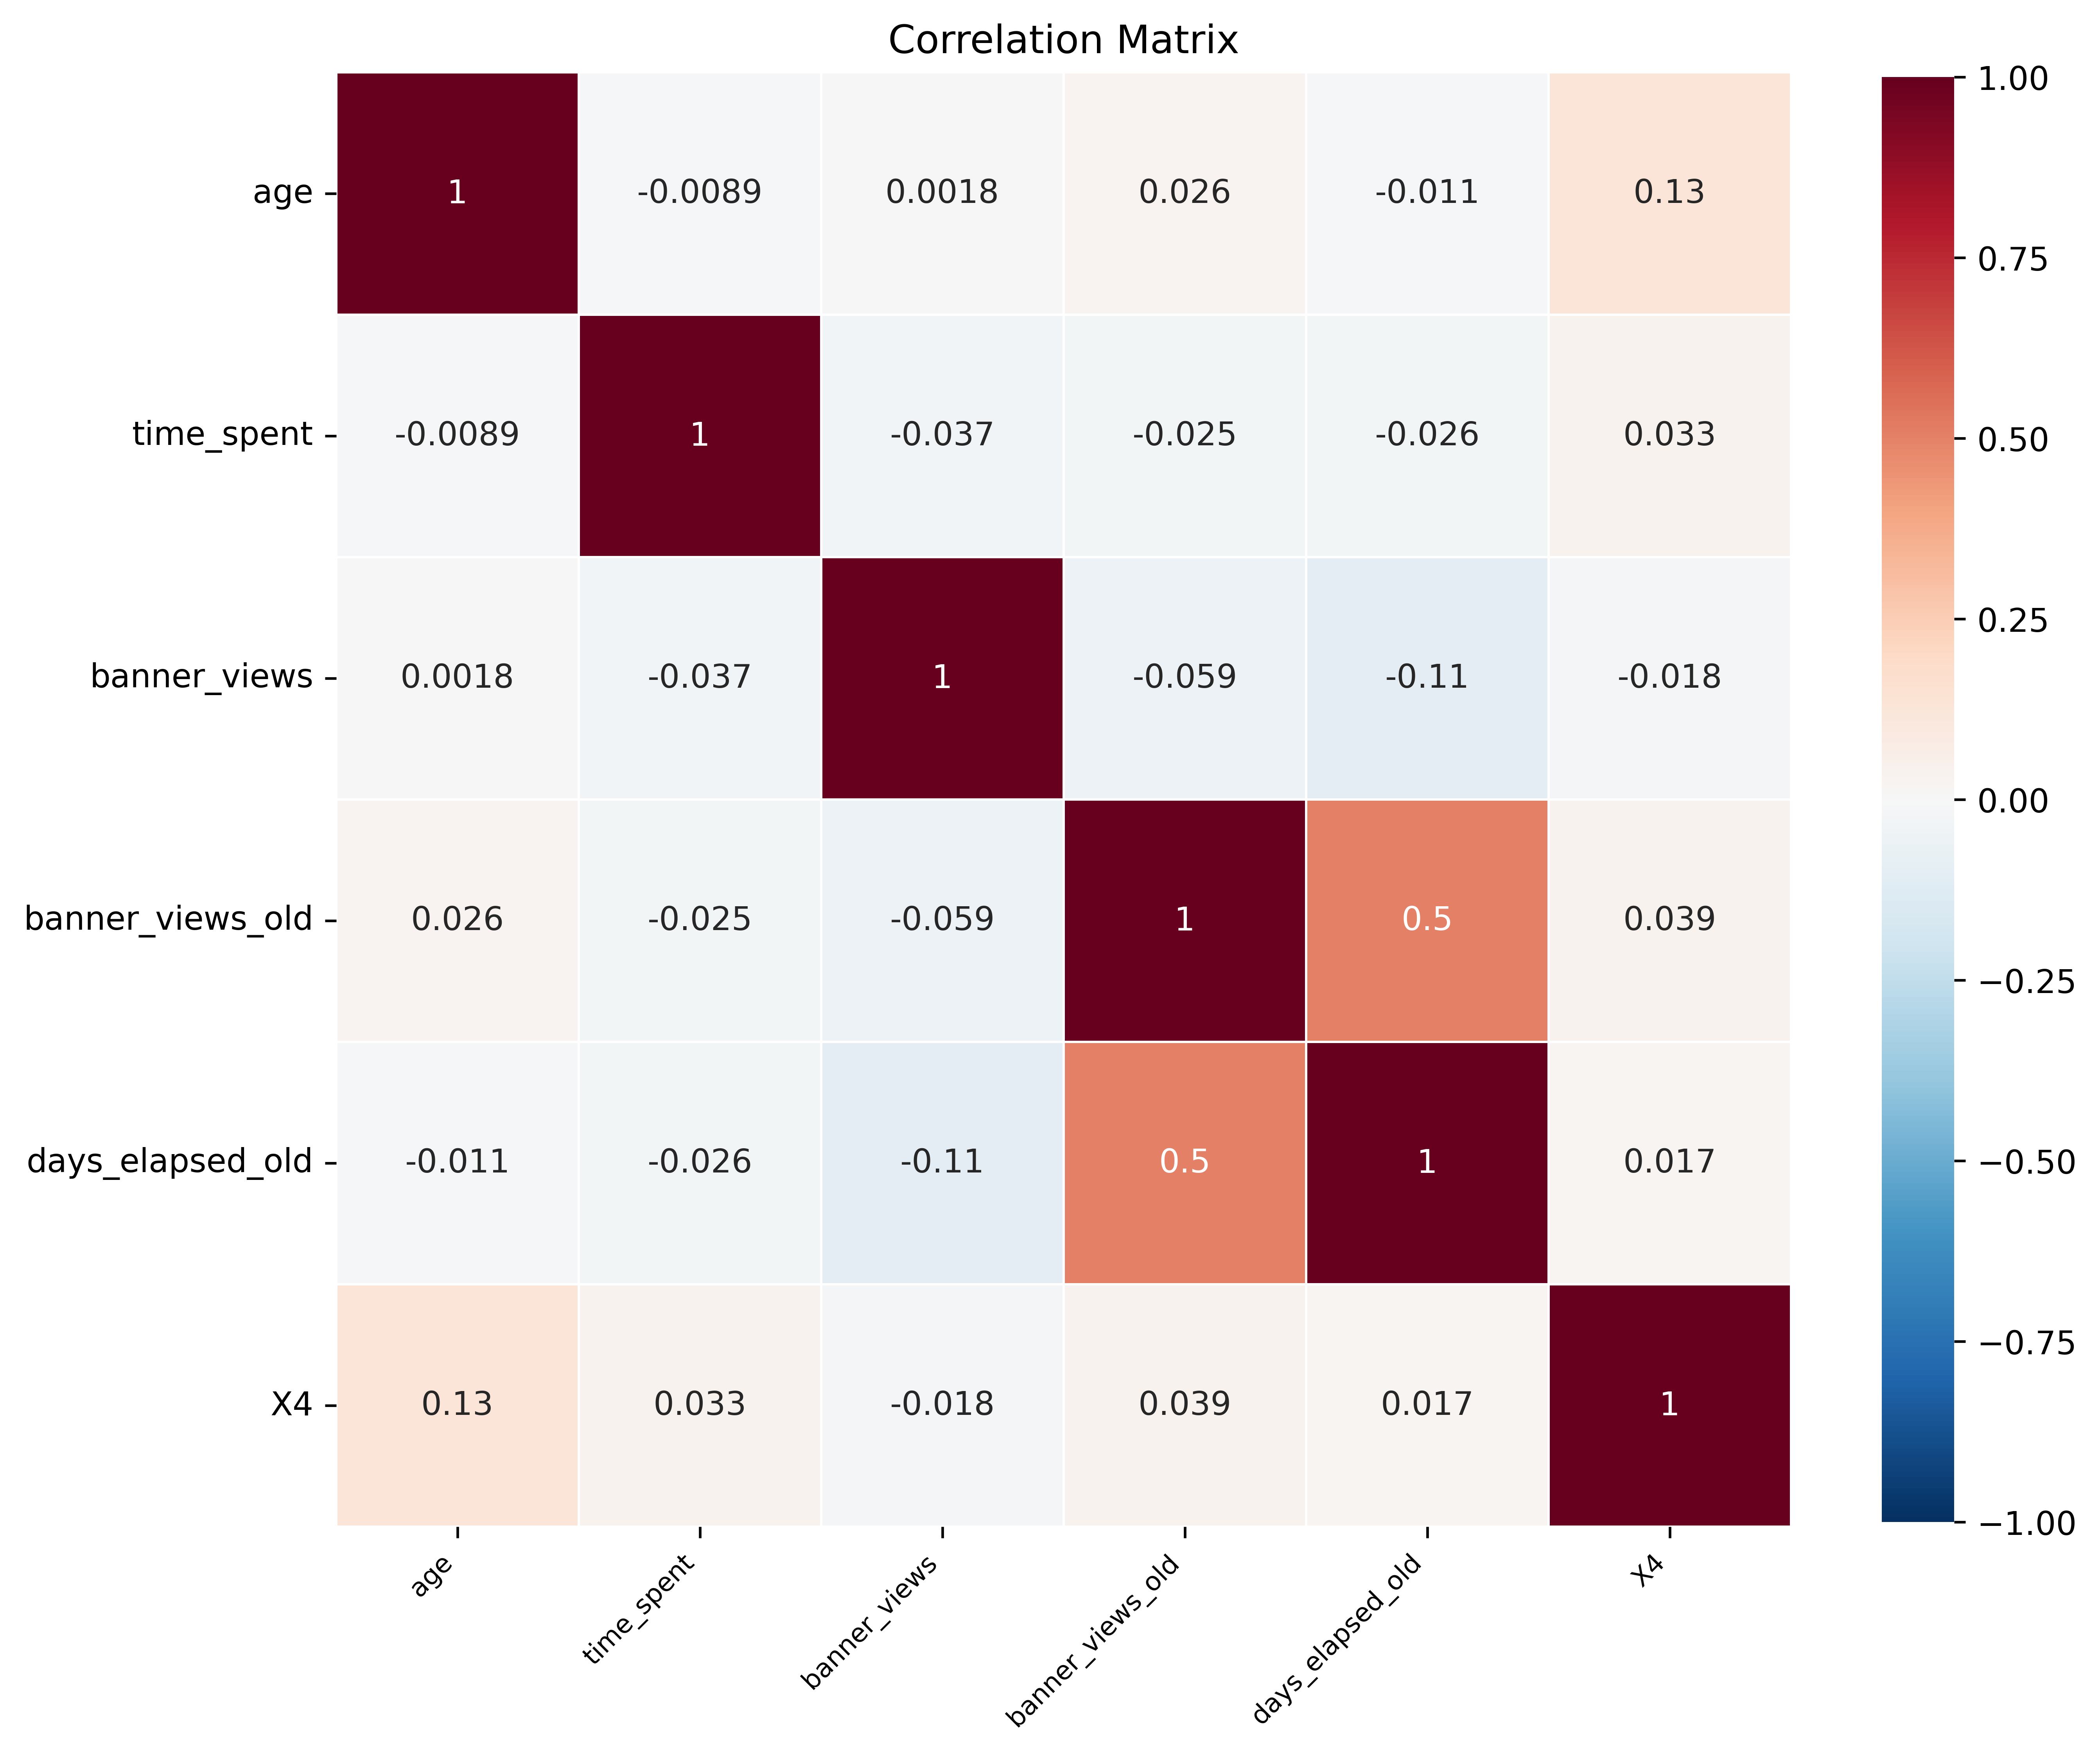

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = X_train_continous.corr()

# Plot correlation matrix

plt.figure(figsize=(10, 10),dpi=600)
g=sns.heatmap(corr_matrix, square=True,
            center=0, annot=True, linewidths=.5,
            cmap="RdBu_r", cbar_kws={"shrink": 0.8},vmin=-1,vmax=1);
g.set_xticklabels(g.get_xticklabels(),rotation=45,fontsize=8,ha='right')
plt.title('Correlation Matrix')


In [5]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Only revewing continuous/numerical variables for their VIF value
X_train_VIF = X_train_continous

vif_data = pd.DataFrame()
vif_data["feature"] = X_train_VIF.columns
  
# Calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train_VIF.values, i)
                          for i in range(len(X_train_VIF.columns))]
vif_data

,feature,VIF
0,age,6.993305
1,time_spent,1.923784
2,banner_views,1.730759
3,banner_views_old,1.520522
4,days_elapsed_old,1.617875
5,X4,6.595099


In [6]:
# Normalize continuous variables
transformers = [
    ('power_transform', PowerTransformer(standardize = True), num_vars)  # Power transformation and Standardization
]

std_num = ColumnTransformer(transformers=transformers, remainder='passthrough')

In [7]:
pipe_LDA = Pipeline([
    ('std_num', std_num),
    ("lda", LinearDiscriminantAnalysis())])

In [8]:
y_train = np.array(y_train)
y_train = y_train.ravel()

In [9]:
# Fit pipeline
pipe_LDA.fit(X_train_continous, y_train) # Fit it to the training data 

# Predict on training data
y_train_pred = pipe_LDA.predict(X_train_continous) # Predict the class labels for the training data
acc = accuracy_score(y_train, y_train_pred) # Calculate the accuracy of the predictions 
print("LDA --- Accuracy on training data:", np.round(acc, 3))

# Predict on valid data
y_valid_pred = pipe_LDA.predict(X_valid_continous) # Predict the class labels for the valid data
acc = accuracy_score(y_valid, y_valid_pred) # Calculate the accuracy of the predictions 
print("LDA --- Accuracy on valid data:", np.round(acc, 3))

# Predict on test data
y_test_pred = pipe_LDA.predict(X_test_continous) # Predict the class labels for the test data
acc = accuracy_score(y_test, y_test_pred) # Calculate the accuracy of the predictions 
print("LDA --- Accuracy on test data:", np.round(acc, 3))

LDA --- Accuracy on training data: 0.782
LDA --- Accuracy on valid data: 0.762
LDA --- Accuracy on test data: 0.793


No overfitting!

In [10]:
# Tune LDA Hyperparameters
LDA = LinearDiscriminantAnalysis(shrinkage = 'auto')

# Define model evaluation method
cv=KFold(n_splits=10, shuffle=True, random_state=42)

lda_param_grid = {"solver" : ['lsqr', 'eigen'],
              "tol" : [0.0001,0.0002,0.0003]}

gsLDA = GridSearchCV(estimator=LDA, param_grid = lda_param_grid, cv=cv,
                     scoring="accuracy", n_jobs= -1, verbose = 1)

gsLDA.fit(X_train,y_train)
y_pred_1 =gsLDA.predict(X_test)
LDA_best = gsLDA.best_estimator_

# Best score
gsLDA.best_score_


Fitting 10 folds for each of 6 candidates, totalling 60 fits


0.7997098103958706

In [11]:
# Tune LDA Hyperparameters
LDA = LinearDiscriminantAnalysis(solver='svd',)

# Define model evaluation method
cv=KFold(n_splits=10, shuffle=True, random_state=42)

lda_param_grid = {
    'n_components': (0,5,1),
    'store_covariance' :(True, False),
                   }

gsLDA2 = GridSearchCV(estimator=LDA, param_grid = lda_param_grid, cv=cv,
                     scoring="accuracy", n_jobs= -1, verbose = 1)

gsLDA2.fit(X_train,y_train)
y_pred_2 =gsLDA2.predict(X_test)
LDA_best = gsLDA2.best_estimator_

# Best score
gsLDA2.best_score_

Fitting 10 folds for each of 6 candidates, totalling 60 fits


c:\Users\emann\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\emann\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\emann\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py", line 576, in fit
    raise ValueError(
ValueError: n_components cannot be larger than min(n_features, n_classes - 1).

  warnings.warn(some_fits_failed_message, FitFailedWarning)
c:\Users\emann\anaconda3\lib\site-packages\sk

0.7992308319448054

In [12]:
# Define pipeline
pipe_QDA = Pipeline(
    [("power", PowerTransformer()), 
     ("qda", QuadraticDiscriminantAnalysis())])

In [13]:
# Fit pipeline
pipe_QDA.fit(X_train_continous, y_train) # Fit it to the training data 

Pipeline(steps=[('power', PowerTransformer()),
                ('qda', QuadraticDiscriminantAnalysis())])

In [14]:
# Add noise before fitting again
def add_noise(X, scale):
    """
    DataFrame double -> ndarray
    produce DataFrame adding Gaussian with standard deviation = `scale` to each column of `X`.
    """
    # Transform to ndarray
    X_arr = X.to_numpy()

    # Get shape
    n, d = X_arr.shape

    # Add Gaussian noise
    X_arr = X_arr + np.random.normal(scale = scale, size = (n, d))

    # Back to DataFrame
    df = pd.DataFrame(X_arr, columns = ["X" + str(i) for i in range(1, d + 1)])

    # Return df
    return df

X_train_noise = add_noise(X_train_continous, scale = 0.1) # Add random noise to the input and controls the amount of the noise added
pipe_QDA.fit(X_train_noise, y_train) # Fit it to the training data 

Pipeline(steps=[('power', PowerTransformer()),
                ('qda', QuadraticDiscriminantAnalysis())])

In [15]:
# Predict on training data
y_train_pred = pipe_QDA.predict(X_train_continous) # Predict the class labels for the training data
acc = accuracy_score(y_train, y_train_pred) # Calculate the accuracy of the predictions 
print("QDA --- Accuracy on training data:", np.round(acc, 3))

# Predict on validation data
y_valid_pred = pipe_QDA.predict(X_valid_continous) # Predict the class labels for the valid data
acc = accuracy_score(y_valid, y_valid_pred) # Calculate the accuracy of the predictions 
print("QDA --- Accuracy on valid data:", np.round(acc, 3))

# Predict on test data
y_test_pred = pipe_QDA.predict(X_test_continous) # Predict the class labels for the test data
acc = accuracy_score(y_test, y_test_pred) # Calculate the accuracy of the predictions 
print("QDA --- Accuracy on test data:", np.round(acc, 3))

QDA --- Accuracy on training data: 0.78
QDA --- Accuracy on valid data: 0.762
QDA --- Accuracy on test data: 0.789


c:\Users\emann\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- age
- banner_views
- banner_views_old
- days_elapsed_old
- time_spent
Feature names seen at fit time, yet now missing:
- X1
- X2
- X3
- X5
- X6

  warnings.warn(message, FutureWarning)
c:\Users\emann\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- age
- banner_views
- banner_views_old
- days_elapsed_old
- time_spent
Feature names seen at fit time, yet now missing:
- X1
- X2
- X3
- X5
- X6

  warnings.warn(message, FutureWarning)
c:\Users\emann\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an erro

_____________________________________________________________________________________________________________________________________________________________________

https://www.datasklr.com/select-classification-methods/linear-and-quadratic-discriminant-analysis

In [19]:
X_train = X_train_continous
X_valid = X_valid_continous
X_test = X_test_continous

# Create interaction terms (interaction of each regressor pair + polynomial)
#Interaction terms need to be created in both the test and train datasets
interaction2 = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False, order='C') #second degree

# Training
X_train_2 = pd.DataFrame(interaction2.fit_transform(X_train), columns=interaction2.get_feature_names(input_features=X_train.columns))

# Validation
X_valid_2 = pd.DataFrame(interaction2.fit_transform(X_valid), columns=interaction2.get_feature_names(input_features=X_valid.columns))

# Test
X_test_2 = pd.DataFrame(interaction2.fit_transform(X_test), columns=interaction2.get_feature_names(input_features=X_train.columns))


c:\Users\emann\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\emann\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\emann\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [20]:
#############################
## Normalize all datasets 
#############################
power = PowerTransformer()

# Normalize the training sets: 1st, 2nd and 3rd order polynomials
X_train=pd.DataFrame(power.fit_transform(X_train), columns=X_train.columns)
X_train_2=pd.DataFrame(power.fit_transform(X_train_2), columns=X_train_2.columns)

# Normalize the validation sets: 1st, 2nd and 3rd order polynomials
X_valid=pd.DataFrame(power.fit_transform(X_valid), columns=X_valid.columns)
X_valid_2=pd.DataFrame(power.fit_transform(X_valid_2), columns=X_valid_2.columns)

# Normalize the test sets: 1st, 2nd and 3rd order polynomials
X_test=pd.DataFrame(power.fit_transform(X_test), columns=X_test.columns)
X_test_2=pd.DataFrame(power.fit_transform(X_test_2), columns=X_test_2.columns)

c:\Users\emann\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
c:\Users\emann\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
c:\Users\emann\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [21]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# cannot compute VIF with m dummies because they are perfectly correlated, need to delete one of each variable to have m-1
X_train_VIF = X_train_continous

vif_data = pd.DataFrame()
vif_data["feature"] = X_train_VIF.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train_VIF.values, i)
                          for i in range(len(X_train_VIF.columns))]
vif_data

,feature,VIF
0,age,6.993305
1,time_spent,1.923784
2,banner_views,1.730759
3,banner_views_old,1.520522
4,days_elapsed_old,1.617875
5,X4,6.595099


In [22]:
################################
## Deal with multicollinearity
################################

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#1st order polynomial ######################
x_temp_train1 = sm.add_constant(X_train)
vif_train1 = pd.DataFrame()
vif_train1["VIF Factor"] = [variance_inflation_factor(x_temp_train1.values, i) for i in range(x_temp_train1.values.shape[1])]
vif_train1["features"] = x_temp_train1.columns
pd.set_option('display.max_rows', 300)
print(vif_train1.round(1))

vif_train1_a=vif_train1[vif_train1["VIF Factor"]<5.0] #identify all variables wit VIF less then 5 and keep
#print(vif2.round(1))

feat_list=vif_train1_a["features"].tolist()  #save desired features to list
feat_list.remove(feat_list[0])
print(feat_list)

X_train=X_train[feat_list] #keep features on feature list only, drop all other features for train
X_valid=X_valid[feat_list]   #keep features on feature list only, drop all other features for valid
X_test=X_test[feat_list]   #keep features on feature list only, drop all other features for test

   VIF Factor          features
0         1.0             const
1         1.0               age
2         1.0        time_spent
3         1.0      banner_views
4       139.9  banner_views_old
5       140.0  days_elapsed_old
6         1.0                X4
['age', 'time_spent', 'banner_views', 'X4']


In [32]:
#2nd order polynomial ####################
x_temp_train2 = sm.add_constant(X_train_2)
vif_train2 = pd.DataFrame()
vif_train2["VIF Factor"] = [variance_inflation_factor(x_temp_train2.values, i) for i in range(x_temp_train2.values.shape[1])]
vif_train2["features"] = x_temp_train2.columns
pd.set_option('display.max_rows', 300)
#print(vif_train1.round(1))

vif_train2_a=vif_train2[vif_train2["VIF Factor"]<5.0]
#print(vif2.round(1))

feat_list2=vif_train2_a["features"].tolist()
feat_list2.remove(feat_list2[0])
print(feat_list2)

X_train_2=X_train_2[feat_list2] #keep features on feature list only, drop all other features for train
X_valid_2=X_valid_2[feat_list2] #keep features on feature list only, drop all other features for valid
X_test_2=X_test_2[feat_list2]   #keep features on feature list only, drop all other features for test
X_valid_2

['time_spent days_elapsed_old', 'banner_views days_elapsed_old']


,time_spent days_elapsed_old,banner_views days_elapsed_old
0,0.122124,-0.719139
1,0.107732,-0.578463
2,1.022678,0.837878
3,0.087147,-0.237896
4,0.150264,-1.794928
...,...,...
1338,0.033102,-0.156509
1339,-0.048896,-0.156509
1340,0.083929,-0.871807
1341,0.180822,-0.336611


In [33]:
#Default LDA model without any tuning - base metric
LDA_model_default = LinearDiscriminantAnalysis()
LDA_model_default.fit(X_train, y_train)
y_pred_LDA_default =LDA_model_default.predict(X_valid)

In [51]:
#Parameter tuning with GridSearchCV 

#######################
### LDA  - lsqr & eigen
#######################

estimator_1 = LinearDiscriminantAnalysis(shrinkage='auto')
parameters_1 = {
    'solver': ('lsqr','eigen'),  #note svd does not run with shrinkage and models using it will be tuned separately
    'n_components': (1,5,1),
                   }
# with GridSearch
grid_search_lda_A = GridSearchCV(
    estimator=estimator_1,
    param_grid=parameters_1,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5
)
lda_A1=grid_search_lda_A.fit(X_train, y_train)
y_pred_1 =lda_A1.predict(X_valid)

lda_A2=grid_search_lda_A.fit(X_train_2, y_train)
y_pred_2 =lda_A2.predict(X_valid_2)

lda_A3=grid_search_lda_A.fit(X_train, y_train)
y_pred_18 =lda_A1.predict(X_test)

lda_A4=grid_search_lda_A.fit(X_train_2, y_train)
y_pred_19 =lda_A2.predict(X_test_2)


c:\Users\emann\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\emann\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\emann\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py", line 576, in fit
    raise ValueError(
ValueError: n_components cannot be larger than min(n_features, n_classes - 1).

  warnings.warn(some_fits_failed_message, FitFailedWarning)
c:\Users\emann\anaconda3\lib\site-packages\sk

In [49]:
#Parameter tuning with GridSearchCV 

#######################
### LDA  - svd
#######################

estimator_2 = LinearDiscriminantAnalysis(solver='svd', )#note svd does not run with shrinkage and models using it will be tuned separately
parameters_2 = {
    'n_components': (0,5,1),
    'store_covariance' :(True, False),
                   }
# with GridSearch
grid_search_lda_B = GridSearchCV(
    estimator=estimator_2,
    param_grid=parameters_2,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5
)
lda_B1=grid_search_lda_B.fit(X_train, y_train)
y_pred_4 =lda_B1.predict(X_valid)

lda_B2=grid_search_lda_B.fit(X_train_2, y_train)
y_pred_5 =lda_B2.predict(X_valid_2)

lda_B3=grid_search_lda_B.fit(X_train, y_train)
y_pred_16 =lda_B1.predict(X_test)

lda_B4=grid_search_lda_B.fit(X_train_2, y_train)
y_pred_17 =lda_B2.predict(X_test_2)

c:\Users\emann\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\emann\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\emann\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py", line 576, in fit
    raise ValueError(
ValueError: n_components cannot be larger than min(n_features, n_classes - 1).

  warnings.warn(some_fits_failed_message, FitFailedWarning)
c:\Users\emann\anaconda3\lib\site-packages\sk

In [46]:
#Base QDA Without any tuning
QDA_model_default = QuadraticDiscriminantAnalysis()
QDA_model_default.fit(X_train, y_train)
y_pred_QDA_default =QDA_model_default.predict(X_test)

#Parameter tuning with GridSearchCV 
#######################
### QDA
#######################

estimator_3 = QuadraticDiscriminantAnalysis()
parameters_3 = {
    'reg_param': (0.00001, 0.0001, 0.001,0.01, 0.1), 
    'store_covariance': (True, False),
    'tol': (0.0001, 0.001,0.01, 0.1), 
                   }
# with GridSearch
grid_search_qda = GridSearchCV(
    estimator=estimator_3,
    param_grid=parameters_3,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5
)
qda_1=grid_search_qda.fit(X_train, y_train)
y_pred_7 =qda_1.predict(X_valid)

qda_2=grid_search_qda.fit(X_train_2, y_train)
y_pred_8 =qda_2.predict(X_valid_2)

qda_3=grid_search_qda.fit(X_train, y_train)
y_pred_14 =qda_1.predict(X_test)

qda_3=grid_search_qda.fit(X_train_2, y_train)
y_pred_15 =qda_2.predict(X_test_2)

In [44]:
from sklearn.naive_bayes import GaussianNB

#Parameter tuning with GridSearchCV 

##########################
### QGaussian Naive Bayes
##########################


estimator_4 = GaussianNB()
parameters_4 = {
    'var_smoothing': (0,1e-9,1e-7, 1e-5), 
                   }
# with GridSearch
grid_search_gnb = GridSearchCV(
    estimator=estimator_4,
    param_grid=parameters_4,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5
)
gnb_1=grid_search_gnb.fit(X_train, y_train)
y_pred_10 =gnb_1.predict(X_valid)

gnb_2=grid_search_gnb.fit(X_train_2, y_train)
y_pred_11 =gnb_2.predict(X_valid_2)

gnb_3=grid_search_gnb.fit(X_train, y_train)
y_pred_12 =gnb_1.predict(X_test)

gnb_3=grid_search_gnb.fit(X_train_2, y_train)
y_pred_13 =gnb_2.predict(X_test_2)

In [52]:
print('Accuracy Score - LDA -Default:', metrics.accuracy_score(y_test, y_pred_LDA_default))  
print('Accuracy Score - LDA - Poly =1 (lsqr & eigen), (valid):', metrics.accuracy_score(y_test, y_pred_1)) 
print('Accuracy Score - LDA - Poly = 2 (lsqr & eigen), (valid):', metrics.accuracy_score(y_test, y_pred_2)) 
print('Accuracy Score - LDA - Poly =1 (lsqr & eigen), (test):', metrics.accuracy_score(y_test, y_pred_18)) 
print('Accuracy Score - LDA - Poly = 2 (lsqr & eigen), (test):', metrics.accuracy_score(y_test, y_pred_19)) 
print('')
print('Accuracy Score - LDA - Poly =1: (svd), (valid):', metrics.accuracy_score(y_test, y_pred_4)) 
print('Accuracy Score - LDA - Poly = 2 (svd), (valid):', metrics.accuracy_score(y_test, y_pred_5)) 
print('Accuracy Score - LDA - Poly =1: (svd), (test):', metrics.accuracy_score(y_test, y_pred_16)) 
print('Accuracy Score - LDA - Poly = 2 (svd), (test):', metrics.accuracy_score(y_test, y_pred_17)) 
print('')
print('Accuracy Score - QDA -Default:', metrics.accuracy_score(y_test, y_pred_QDA_default))  
print('Accuracy Score - QDA - Poly =1 (valid):', metrics.accuracy_score(y_test, y_pred_7)) 
print('Accuracy Score - QDA - Poly = 2 (valid):', metrics.accuracy_score(y_test, y_pred_8)) 
print('Accuracy Score - QDA - Poly =1 (test):', metrics.accuracy_score(y_test, y_pred_14)) 
print('Accuracy Score - QDA - Poly = 2 (test):', metrics.accuracy_score(y_test, y_pred_15)) 
print('') 
print('Accuracy Score - Gaussian Naive Bayes - Poly =1 (valid):', metrics.accuracy_score(y_test, y_pred_10)) 
print('Accuracy Score - Gaussian Naive Bayes - Poly = 2 (valid):', metrics.accuracy_score(y_test, y_pred_11)) 
print('Accuracy Score - Gaussian Naive Bayes - Poly =1 (test):', metrics.accuracy_score(y_test, y_pred_12)) 
print('Accuracy Score - Gaussian Naive Bayes - Poly = 2 (test):', metrics.accuracy_score(y_test, y_pred_13)) 

Accuracy Score - LDA -Default: 0.4996276991809382
Accuracy Score - LDA - Poly =1 (lsqr & eigen), (valid): 0.501861504095309
Accuracy Score - LDA - Poly = 2 (lsqr & eigen), (valid): 0.5569620253164557
Accuracy Score - LDA - Poly =1 (lsqr & eigen), (test): 0.7587490692479524
Accuracy Score - LDA - Poly = 2 (lsqr & eigen), (test): 0.6344005956813105

Accuracy Score - LDA - Poly =1: (svd), (valid): 0.4996276991809382
Accuracy Score - LDA - Poly = 2 (svd), (valid): 0.552494415487714
Accuracy Score - LDA - Poly =1: (svd), (test): 0.759493670886076
Accuracy Score - LDA - Poly = 2 (svd), (test): 0.6388682055100521

Accuracy Score - QDA -Default: 0.763216679076694
Accuracy Score - QDA - Poly =1 (valid): 0.49069247952345496
Accuracy Score - QDA - Poly = 2 (valid): 0.5316455696202531
Accuracy Score - QDA - Poly =1 (test): 0.7639612807148176
Accuracy Score - QDA - Poly = 2 (test): 0.7542814594192108

Accuracy Score - Gaussian Naive Bayes - Poly =1 (valid): 0.49664929262844376
Accuracy Score - Gaus